In [1]:
import random
from itertools import permutations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deap import base
from deap import tools
from deap import creator
from deap import algorithms

# Algoritmos genéticos

- É uma classe de algoritmos usada, em geral, para resolver problemas de otimização cuja solução exata seja computacionalmente muito custosa de encontrar. Assim, a ideia é encontrar uma solução <em>boa</em>, mas não necessariamente <em>ótima</em> (no sentido matemático: a melhor possível).


- Existem vários tipos, mas a ideia básica é gerar um monte de soluções tentativas pro problema e combinar aquelas
que se mostrem as melhores pra gerar novas soluções que sejam melhores ainda.


- O nome vem da inspiração biológica: "genes" mais "adaptados ao ambiente" (isto é, soluções mais próximas da solução ótima) tendem a se propagar na população, fazendo com que as características mais adaptadas àquele ambiente se tornem dominantes com o passar das gerações.

![](https://raw.githubusercontent.com/GCozzella/projects/master/genetic_algorithms/Genes.png)

#  Um pouco de teoria sobre

Precisamos definir algumas coisas:

- Uma função de adequação (<em><b>fitness</b></em>) que esteja relacionada com o que queremos otimizar. 
    - Por exemplo, $f(x) = x^4+x^3+x^2+7x+2000 \sin{(x)}$, cujo mínimo global é em $x \approx -1.57$. 
    

- As características (os <em><b>genes</b></em>) de uma solução proposta (um <em><b>cromossomo</b></em>).
    - No caso, a coordenada $x$ da solução (se fossem um problema 2D, os genes seriam as coordenadas $x$ e $y$ e o cromossomo o ponto $(x,y)$).
    
    
- Uma <em><b>população</b></em> desses indivíduos.
    - $N$ pontos $x_i$.
    
    
- Uma maneira de <em><b>mutar</b></em> esses indivíduos pra que eles possivelmente se aproximem da solução ótima.
    - Por exemplo, adicionar ou subtrair um valor pequeno em $x_i$.
    
    
- Uma maneira de <em><b>selecionar</b></em> esses indivíduos pra que eles se aproximem da solução ótima.
    - Por exemplo, escolher $N/2$ valores de $X=\{x_i\}$ na população tais que o valor nesse conjunto, $f(X)$, seja o menor possível.
    
    
- Uma maneira de <em><b>gerar novos indivíduos</b></em> pra população a partir dos melhores da geração anterior.
    - Por exemplo, pra cada dois geradores $x_i$ e $x_j$ tomamos duas médias ponderadas, $x_1' = w_1 x_i + w_2 x_j$ e $x_2' = w_2 x_i + w_1 x_j$.

# DEAP (Distributed Evolutionary Algorithms in Python)

Vamos usar o DEAP, que é uma biblioteca do Python especializada em construir algoritmos genéticos.

O primeiro passo é traduzir o problema acima pras ferramentas do DEAP. Boa parte do código aqui saiu direto da documentação da biblioteca que vale a pena consultar (https://deap.readthedocs.io/en/master/index.html).


### Exemplo (1) - Otimizando a função $f(x)$ dada acima.

Vamos ver o formato da função, o que ajuda a entender a distinção entre solução boa/ótima explicada acima.

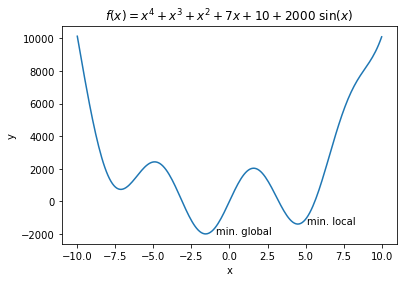

In [2]:
x=np.linspace(-10,10,200)
y=x**4+x**3+x**2+7*x+10+2000*np.sin(x)

plt.plot(x,y)
plt.title('$f(x) = x^4 + x^3 + x^2 + 7 x +10 + 2000 \ \sin{(x)}$')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate(xy=(-0.8687,-1996),s='min. global')
plt.annotate(xy=(5.0912,-1392),s='min. local')
plt.show()

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #Aptidão da solução, problema de minimização
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_gauss", np.random.normal, 100, 1) #Como iniciar o indivíduo

toolbox.register("individual", tools.initRepeat, 
                 creator.Individual, toolbox.attr_gauss, 1) #Gera um número gaussiano

toolbox.register("population", tools.initRepeat, 
                 list, toolbox.individual) #Gera a população 

def eval_f(individual): 
    x = individual[0] 
    f = x**4+x**3+x**2+7*x+10+2000*np.sin(x)
    return (f,)

def cross_x(child1,child2):
    child1[0]=0.3*child1[0]+0.7*child2[0]
    child2[0]=0.7*child1[0]+0.3*child2[0]

toolbox.register("evaluate", eval_f) #Calcula o fitness
toolbox.register("mate", cross_x) #Cruza indivíduos
toolbox.register("mutate", tools.mutGaussian, mu=0,sigma=2,indpb=0.05) #Mutação
toolbox.register("select", tools.selTournament, tournsize=3) #Seleção

#Parâmetros
CXPB, MUTPB = 0.6, 0.1 #Taxas de cruzamento e mutação
N_GEN = 1000
SIZE = 500

#Registro
stats = tools.Statistics(key=lambda ind: ind.fitness.values) #Pra logar a evolução da população
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


def genetic_algorithm():
    pop, record = toolbox.population(n=SIZE), [] #Inicia a população
    
    fitnesses = [*map(toolbox.evaluate, pop)] #Calculando o fitness
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(N_GEN):

        offspring = [*map(toolbox.clone, toolbox.select(pop, len(pop)))] #Gerando a nova população
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]): #Cruzando 0 com 1, 2 com 3, etc.
            if random.random() < CXPB: 
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring: #Mutações
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid] #Recalculando a adequação com cx e mut.
        fitnesses = [*map(toolbox.evaluate, invalid_ind)]
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        pop[:]=offspring
        
        record.append(stats.compile(pop))
        
    return(pop, record)
        
pop,record_1=genetic_algorithm()

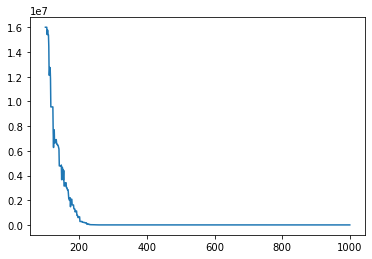

In [4]:
pd.DataFrame(record_1)['min'].iloc[100:].plot()

In [5]:
#Sol. exata
#x = -1.5687
#f = -1996.3203

print(tools.selBest(pop, k=1)[0])

eval_f(tools.selBest(pop, k=1)[0])

[-1.568698297620915]


(-1996.320340029519,)

### Exemplo (2) - Otimizando uma função com vínculos.

Vamos tentar otimizar $f(x,y) = 4x-y$ sujeita aos vínculos:
<ul>
<item>$7x-2y \leq 14$</item>
    
<item>$y \leq 3$</item>
    
<item>$ 2x-2y \leq 3$</item>
    
<item>$ x,y \geq 0$</item>
</ul>

In [6]:
creator.create("Fitness", base.Fitness, weights=(1.0,)) #Prox. de maximização agora
creator.create("Individual", list, fitness=creator.Fitness)

toolbox = base.Toolbox()
toolbox.register("attr_gauss", np.random.normal, 100, 1) #Atributo básico do indivíduo
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_gauss, 2) #Gera um ponto x,y
toolbox.register("population", tools.initRepeat, list, toolbox.individual) #Gera a população 

def eval_f(individual): 
    x, y = individual[0], individual[1]
    f = 4*x-y
    return (f,)

def feasible(individual): #Verificando os vínculos
    x, y = individual[0], individual[1]
    
    if 7*x-2*y > 14:
        return False
    elif y > 3:
        return False
    elif 2*x-2*y > 3:
        return False
    elif x < 0 or y <0:
        return False
    return True

def distance(individual): #Penalidade
    return np.sqrt((individual[0]-4)**2+(individual[1] - 3)**2)

def cross_x(child1,child2):
    child1[0]=0.3*child1[0]+0.7*child2[0]
    child2[0]=0.7*child1[0]+0.3*child2[0]
    
    child1[1]=0.3*child1[1]+0.7*child2[1]
    child2[1]=0.7*child1[1]+0.3*child2[1]
    
def mutate(mutant):
    mutant[0]+=np.random.standard_cauchy()
    mutant[1]+=np.random.standard_cauchy()

toolbox.register("evaluate", eval_f) 
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0,distance)) #Penalizando quem não satisfaz os vínculos

toolbox.register("mate", cross_x)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

#Parâmetros
CXPB, MUTPB = 0.6, 0.1 #Taxas de cruzamento e mutação
N_GEN = 1000
SIZE = 500

#Registro
stats = tools.Statistics(key=lambda ind: ind.fitness.values) #Pra logar a evolução da população
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

def genetic_algorithm():
    pop, record = toolbox.population(n=SIZE), [] #Inicia a população
    
    fitnesses = [*map(toolbox.evaluate, pop)] #Calculando o fitness
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(N_GEN):

        offspring = [*map(toolbox.clone, toolbox.select(pop, len(pop)))] #Gerando a nova população
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]): #Cruzando 0 com 1, 2 com 3, etc.
            if random.random() < CXPB: 
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring: #Mutações
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid] #Recalculando a adequação com cx e mut.
        
        fitnesses = [*map(toolbox.evaluate, invalid_ind)]
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        pop[:]=offspring
        
        record.append(stats.compile(pop))
        
    return(pop, record)
        
pop,record_2=genetic_algorithm()

/home/gabriel/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [7]:
pd.DataFrame(record_2)

,avg,std,min,max
0,-135.657945,1.872253,-151.800759,-106.285017
1,-134.741464,3.842758,-153.417605,-87.385153
2,-136.448477,68.356210,-1650.651100,-96.820000
3,-129.571121,7.364260,-151.807608,-85.006197
4,-123.531822,9.743026,-143.525758,-37.981881
...,...,...,...,...
995,3.968053,53.190129,-1111.727934,8.408709
996,7.004592,10.040744,-203.445819,8.408709
997,6.974136,5.544768,-66.513022,8.408709
998,6.955425,4.358910,-22.174026,8.408709


In [8]:
#Sol. exata: 
#x = 20/7 ~ 2.8571
#y = 3
#f = 59/7 ~ 8.4285

print(tools.selBest(pop, k=1)[0])

eval_f(tools.selBest(pop, k=1)[0])

[2.835303339814425, 2.9325043739040613]


(8.40870898535364,)

### Exemplo (3) - O problema do caixeiro viajante.

O problema consiste em um conjunto de $n$ cidades e as distâncias $d$ entre elas. O objetivo é encontrar uma rota começando da cidade "0" que passe por todas as outras uma única vez e volte pra cidade original com a menor distância percorrida possível. 

A importância do problema do caixeiro viajante vem de que outros problemas podem ser colocados nesses termos, como escolher a melhor rota pra entrega de produtos de uma transportadora em uma cidade.

Um exemplo simétrico com 4 cidades (tirado da Wikipedia, https://en.wikipedia.org/wiki/Travelling_salesman_problem):

![](https://upload.wikimedia.org/wikipedia/commons/3/30/Weighted_K4.svg)

O número de combinações possíveis de serem exploradas é $O((n-1)!)$, o que torna o problema intratável de ser resolvido exatamente por força bruta.

No link (https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb) tem uma discussão legal sobre o problema, de onde também tirei alguns trechos de código pra usar abaixo.

Vamos ver primeiro a solução força-bruta em um caso simples e depois a solução heurística usando um algoritmo genético. Aqui vamos considerar o problema assimétrico, onde as distâncias $d_{ij}$ não precisam ser iguais a $d_{ji}$.

In [9]:
n=300
np.random.seed(0)

In [10]:
#Gerando a matriz de distâncias

d_matrix=np.random.randint(1,20,size=(n,n))

for i in range(n):
    d_matrix[i,i]=0
    
d_matrix

array([[ 0, 16,  1, ..., 19,  3, 12],
       [19,  0,  2, ..., 19,  9, 19],
       [ 8, 11,  0, ..., 11, 10, 17],
       ...,
       [ 9,  2,  4, ...,  0, 11, 11],
       [ 1, 19, 11, ...,  5,  0, 12],
       [15,  7, 12, ..., 16,  1,  0]])

### Cuidado!
Tentar rodar isso aqui com $n$ muito elevado causa um crash pois o número de permutações é enorme.

In [11]:
# valid=[]
# for perm in [*permutations([*range(n)]+[0],n+1)]:
#     if perm[0]==0 and perm[-1]==0:
#         valid.append(perm)    

# valid=list(set(valid)) #Um exemplo
# valid[0]

In [12]:
# total_d=dict()

# for road in valid:
#     total_d[road]=sum([d_matrix[road[i],road[i+1]] for i in range(0,n)])
    
# total_d

In [13]:
# #Vendo a melhor rota

# min_d = np.inf
# best_route = 0

# for key, value in total_d.items():
#     if value < min_d:
#         min_d, best_route = value, key
        
# print(best_route)
# print(min_d)

Agora vamos usar um algoritmo genético de maneira similar ao que fizemos antes. (Ainda não tá funcionando)

In [14]:
def create_route(n):
    route = random.sample([*range(0,n-1)],n-1)
    return route.copy()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("route", create_route, n)
toolbox.register("individual",  tools.initIterate, creator.Individual, toolbox.route) #Gera um número
toolbox.register("population", tools.initRepeat, list, toolbox.individual) #Gera a população 

def eval_f(individual): 
    road=[i+1 for i in individual]    
    fitness=(d_matrix[0,road[0]])+sum([d_matrix[road[i],road[i+1]] for i in range(0,n-2)])+d_matrix[road[-1],0]
    return(fitness,)

toolbox.register("evaluate", eval_f) #Calcula o fitness
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


CXPB, MUTPB = 0.6, 0.1 #Taxas de cruzamento e mutação
N_GEN = 1000
SIZE = 10

pop = toolbox.population(SIZE)
result, record_3 = algorithms.eaSimple(pop, toolbox,
                             cxpb=CXPB, mutpb=MUTPB,
                             ngen=N_GEN, verbose=False,stats=stats)

/home/gabriel/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/gabriel/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
print([0]+[i+1 for i in tools.selBest(pop, k=1)[0]]+[0])

eval_f(tools.selBest(pop, k=1)[0])

[0, 27, 249, 216, 102, 250, 163, 25, 272, 111, 218, 84, 145, 128, 290, 51, 13, 146, 201, 31, 294, 219, 89, 243, 48, 139, 99, 149, 2, 260, 148, 37, 190, 285, 124, 183, 232, 59, 237, 299, 39, 266, 228, 120, 1, 81, 282, 203, 207, 79, 72, 121, 155, 82, 264, 298, 185, 53, 38, 29, 217, 77, 168, 189, 241, 174, 129, 288, 55, 164, 34, 93, 270, 204, 194, 215, 206, 224, 104, 73, 68, 95, 134, 188, 222, 244, 49, 267, 44, 234, 83, 177, 109, 15, 172, 57, 74, 131, 275, 240, 229, 76, 287, 80, 65, 198, 96, 225, 257, 157, 280, 277, 133, 265, 179, 208, 271, 199, 205, 256, 161, 52, 97, 98, 295, 105, 170, 263, 78, 184, 223, 195, 60, 132, 245, 202, 167, 45, 12, 226, 115, 123, 173, 64, 140, 11, 220, 262, 153, 182, 292, 43, 239, 85, 259, 209, 186, 178, 63, 24, 126, 175, 92, 258, 114, 197, 156, 211, 235, 284, 166, 41, 227, 108, 100, 151, 169, 69, 127, 180, 187, 117, 36, 236, 75, 7, 181, 54, 233, 269, 35, 200, 122, 88, 143, 253, 101, 26, 86, 147, 246, 5, 261, 42, 192, 268, 110, 61, 56, 152, 70, 150, 210, 176, 15

(2085,)

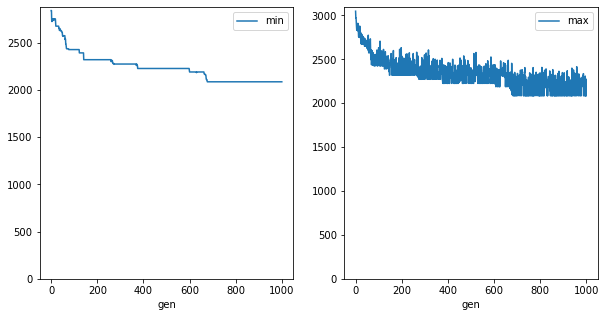

In [16]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
pd.DataFrame(record_3).plot(x='gen',y=['min'],ax=ax[0])
ax[0].set_ylim(bottom=0)
pd.DataFrame(record_3).plot(x='gen',y=['max'],ax=ax[1])
ax[1].set_ylim(bottom=0)
plt.show()